In [178]:
%matplotlib inline

In [179]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

In [180]:
import seaborn as sns
import shutil
from sklearn.utils import shuffle

# Importando base de dados

In [181]:
dfm = pd.read_csv('../data/derivaded_3.csv',index_col=0)
print (len(dfm))
dfm = dfm.drop('prcp_plus_12',1)
dfm.head(3)

27721


,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,dmax_16,dmax_17,dmax_18,dmax_19,dmax_20,dmax_21,dmax_22,dmax_23,dmax_24,prcp_acum_24
0,0.0,918.2,918.2,917.5,18.8,17.1,20.2,17.1,18.8,16.2,...,19.9,20.2,20.1,20.2,20.4,20.6,20.5,20.7,20.4,2.0
1,0.4,918.7,918.7,918.2,18.6,17.2,18.9,17.2,18.6,17.1,...,19.9,19.9,20.2,20.1,20.2,20.4,20.6,20.5,20.7,2.0
2,1.0,918.7,918.8,918.7,18.4,17.3,18.6,17.4,18.3,17.2,...,20.6,19.9,19.9,20.2,20.1,20.2,20.4,20.6,20.5,1.6


<h2>Mineiração dos dados</h2>

<p>Criando classes para sem chuva, chuva e chuva extrema</p>

In [182]:
def f(x):
    if x['prcp_acum_24'] <= 0.0: 
        return 0
    elif x['prcp_acum_24'] < 50:       
        return 1
    else:
        return 2

In [183]:
dfm.loc[:,('rain')] = dfm.loc[:,].apply(f,axis=1) 

In [184]:
dfm.head(3)

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,dmax_17,dmax_18,dmax_19,dmax_20,dmax_21,dmax_22,dmax_23,dmax_24,prcp_acum_24,rain
0,0.0,918.2,918.2,917.5,18.8,17.1,20.2,17.1,18.8,16.2,...,20.2,20.1,20.2,20.4,20.6,20.5,20.7,20.4,2.0,1
1,0.4,918.7,918.7,918.2,18.6,17.2,18.9,17.2,18.6,17.1,...,19.9,20.2,20.1,20.2,20.4,20.6,20.5,20.7,2.0,1
2,1.0,918.7,918.8,918.7,18.4,17.3,18.6,17.4,18.3,17.2,...,19.9,19.9,20.2,20.1,20.2,20.4,20.6,20.5,1.6,1


<h3>Scalling</h3>

In [185]:
target = 'rain'

In [186]:
y = dfm.pop(target)
X = dfm[[col for col in dfm.columns]]

In [187]:
X.head(3)

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,dmax_16,dmax_17,dmax_18,dmax_19,dmax_20,dmax_21,dmax_22,dmax_23,dmax_24,prcp_acum_24
0,0.0,918.2,918.2,917.5,18.8,17.1,20.2,17.1,18.8,16.2,...,19.9,20.2,20.1,20.2,20.4,20.6,20.5,20.7,20.4,2.0
1,0.4,918.7,918.7,918.2,18.6,17.2,18.9,17.2,18.6,17.1,...,19.9,19.9,20.2,20.1,20.2,20.4,20.6,20.5,20.7,2.0
2,1.0,918.7,918.8,918.7,18.4,17.3,18.6,17.4,18.3,17.2,...,20.6,19.9,19.9,20.2,20.1,20.2,20.4,20.6,20.5,1.6


In [188]:
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler(feature_range=(-0.8, 0.8))
X_scales = scale.fit_transform(X,y)

In [189]:
X_scales

array([[-0.8       ,  0.25762712,  0.24545455, ..., -0.27283237,
        -0.30057803, -0.78113208],
       [-0.79183673,  0.30282486,  0.29090909, ..., -0.29132948,
        -0.27283237, -0.78113208],
       [-0.77959184,  0.30282486,  0.3       , ..., -0.28208092,
        -0.29132948, -0.78490566],
       ...,
       [-0.8       ,  0.48361582,  0.47272727, ...,  0.09710983,
         0.11560694, -0.8       ],
       [-0.8       ,  0.51977401,  0.51818182, ...,  0.06936416,
         0.09710983, -0.8       ],
       [-0.8       ,  0.56497175,  0.56363636, ...,  0.05086705,
         0.06936416, -0.8       ]])

<h3>Rede neural</h3>

In [190]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import explained_variance_score, mean_absolute_error,  median_absolute_error

In [191]:
from sklearn.model_selection import StratifiedKFold

In [197]:
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc

<p>Separando o conjunto de testes</p>

In [192]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [193]:
# Zarate instructions
st_units = (X_train.shape[1] * 2) + 1
fn_activation='logistic'

In [194]:
nn = MLPRegressor(
    hidden_layer_sizes=(st_units,),  activation=fn_activation, learning_rate_init=0.01
    )

In [195]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state =45)
pred_test_full =0
cv_score =[]
i=1

In [199]:
for train_index,test_index in kf.split(X_train,y_train):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y.loc[train_index],y.loc[test_index]
    
    nn.fit(xtr,ytr)
    score = roc_auc_score(yvl,nn.predict(xvl))
    print('ROC AUC score:',score)
    cv_score.append(score)    
    pred_test = nn.predict_proba(X_test)[:,1]
    pred_test_full +=pred_test
    i+=1
    

1 of KFold 10


ValueError: multiclass format is not supported

In [ ]:

cross_val_score(est, boston.data, boston.target, cv=10)


In [16]:
from imblearn.under_sampling import RandomUnderSampler
under = RandomUnderSampler(return_indices=True)

In [17]:
def balancear(_X, _y):
    
    def f(x):
        if x['prcp_acum_24'] <= 0.0: 
            return 0
        elif x['prcp_acum_24'] < 50:       
            return 1
        else:
            return 2        
        
    #Balancear considerando considerando: a) sem chuva b) chuva  c) chuva extrema  
    _X.loc[:,('rain')] = _X.apply(f,axis=1) 
    
    _X_resampled, _y_resampled, idx_resampled = under.fit_sample(_X, _X['rain'])
    
    _X = pd.DataFrame(_X_resampled, columns = _X.columns)
    _y = pd.DataFrame(_y_resampled, columns =['prcp_acum_24'])
    
    for c in ['prcp_acum_24','rain']:
        _X = _X.drop(c,1)
    
    return _X,_y

In [18]:
#X_val = X_val.drop('prcp_plus_12',1)
#X_val = X_val.drop('prcp_acum_24',1)
#X_train =  X_train.drop('prcp_plus_12',1)
#X_train =  X_train.drop('prcp_acum_24',1)

In [19]:
def f(x):
    if x['prcp_acum_24'] <= 0.0: 
        return 0
    elif x['prcp_acum_24'] < 50:       
        return 1
    else:
        return 2   

In [20]:
#A, b = balancear(X_train, y_train)

In [21]:
#A.loc[:,('prcp')] = A.loc[:,].apply(f,axis=1) 

In [22]:
#g = A.groupby('rain')
#g.count()

In [23]:
#b.groupby(pd.cut(b.values, [-50,   0,  49.99, 200])).count()

In [24]:
#len(A)

In [25]:
X_train

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,dmax_17,dmax_18,dmax_19,dmax_20,dmax_21,dmax_22,dmax_23,dmax_24,prcp_acum_24,prcp_plus_12
17121,0.0,917.6,918.3,917.6,21.0,16.1,21.7,16.6,21.0,16.1,...,22.4,22.3,22.5,23.5,23.0,24.1,24.4,24.7,2.6,0.0
6881,0.0,916.3,916.3,916.1,20.3,17.7,20.5,17.9,20.0,17.7,...,26.4,25.6,24.9,23.0,21.4,19.8,19.1,18.4,11.4,0.2
21250,0.4,916.3,916.3,915.5,20.2,18.5,20.4,18.9,19.7,18.4,...,18.6,18.8,19.0,19.5,19.4,20.2,22.5,23.6,2.0,0.8
26825,0.0,916.9,917.1,916.9,23.4,15.4,23.7,15.9,23.3,15.4,...,26.2,25.3,23.1,21.9,21.5,22.4,22.8,22.7,0.0,0.0
26511,0.0,920.1,920.2,920.1,23.7,15.7,23.8,16.0,23.3,15.7,...,22.7,21.9,21.6,22.3,22.8,23.1,23.4,23.4,0.0,0.0
6662,0.0,916.2,916.4,916.1,20.3,18.1,20.3,18.2,20.1,18.1,...,19.6,18.9,18.5,18.3,18.2,18.3,18.7,18.6,0.0,0.0
20087,0.0,921.8,921.9,921.5,23.8,16.7,24.0,17.2,22.3,15.9,...,27.6,27.2,27.2,26.0,24.6,24.1,23.4,22.9,0.0,0.0
21743,5.2,919.8,919.8,919.1,21.1,19.9,22.0,20.7,21.0,19.8,...,29.7,30.3,27.9,28.2,27.0,25.5,24.7,22.8,5.8,5.8
20528,0.0,919.1,919.1,919.0,28.3,13.3,29.0,14.0,27.6,11.4,...,22.2,22.4,22.7,23.3,24.0,25.0,26.3,26.5,0.0,0.0
2996,0.0,916.2,916.5,916.2,20.8,18.6,21.1,18.7,20.6,18.3,...,23.5,22.6,21.8,19.9,19.0,19.0,19.0,19.1,3.0,0.0


In [26]:
from sklearn.preprocessing import MinMaxScaler

scale = MinMaxScaler(feature_range=(-0.8, 0.8))

_X = X_train
for c in ['prcp_plus_12','prcp_acum_24']:
    _X = _X.drop(c,1)
    
scale.fit(_X,y_train)

MinMaxScaler(copy=True, feature_range=(-0.8, 0.8))

In [27]:
#sc_A = scale.transform(_X)

In [28]:
#A = pd.DataFrame(sc_A, columns = _X.columns)

In [ ]:
evaluations = []  
STEPS = 500  

for i in range(1, 100):    
    
    A, b = balancear(X_train, y_train)
    
    sc_A = scale.transform(A)
    A = pd.DataFrame(sc_A, columns = A.columns)
    
    C, d = balancear(X_val, y_val)
    
    sc_C = scale.transform(C)
    C = pd.DataFrame(sc_C, columns = C.columns)
    
    print ('treinando agora...')
    
    regressor.train(input_fn=wx_input_fn(A ,b), steps=STEPS)
    
    evaluations.append(
        regressor.evaluate(input_fn=wx_input_fn(C
                                                ,d
                                                ,num_epochs=1
                                                ,shuffle=False)))

/Users/dedeco/Envs/kaggle/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/dedeco/Envs/kaggle/lib/python3.6/site-packages/pandas/core/indexing.py:621: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_15/model.ckpt-2001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2002 into /tmp/tf_model_15/model.ckpt.
INFO:tensorflow:loss = 305.43036, step = 2002
INFO:tensorflow:global_step/sec: 1.77236
INFO:tensorflow:loss = 508.43, step = 2102 (56.423 sec)
INFO:tensorflow:global_step/sec: 1.55546
INFO:tensorflow:loss = 266.75995, step = 2202 (64.290 sec)
INFO:tensorflow:global_step/sec: 1.51066
INFO:tensorflow:loss = 501.60498, step = 2302 (66.196 sec)
INFO:tensorflow:global_step/sec: 1.97911
INFO:tensorflow:loss = 381.31128, step = 2402 (50.528 sec)
INFO:tensorflow:Saving checkpoints for 2501 into /tmp/tf_model_15/model.ckpt.
INFO:tensorflow:Loss for final step: 478.33398.
INFO:tensorflow:Callin

/Users/dedeco/Envs/kaggle/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_15/model.ckpt-2501
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2502 into /tmp/tf_model_15/model.ckpt.
INFO:tensorflow:loss = 314.3438, step = 2502
INFO:tensorflow:global_step/sec: 2.24226
INFO:tensorflow:loss = 428.40668, step = 2602 (44.599 sec)
INFO:tensorflow:global_step/sec: 2.03366
INFO:tensorflow:loss = 463.15875, step = 2702 (49.172 sec)
INFO:tensorflow:global_step/sec: 1.40371
INFO:tensorflow:loss = 298.07465, step = 2802 (71.240 sec)
INFO:tensorflow:global_step/sec: 1.56664
INFO:tensorflow:loss = 418.92258, step = 2902 (63.831 sec)
INFO:tensorflow:Saving checkpoints for 3001 into /tmp/tf_model_15/model.ckpt.
INFO:tensorflow:Loss for final step: 495.4767.
INFO:tensorflow:Calli

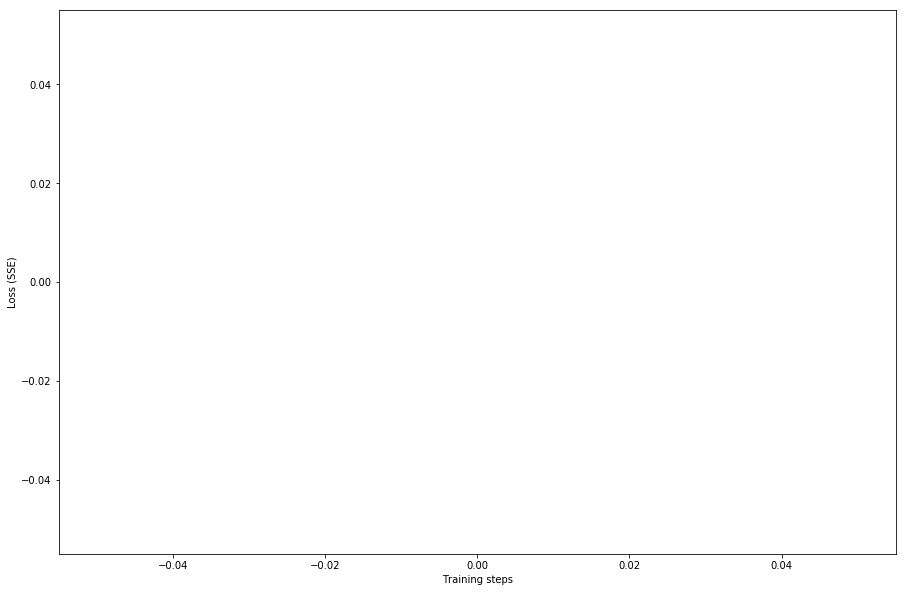

In [29]:
import matplotlib.pyplot as plt  
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 10]

loss_values = [ev['loss'] for ev in evaluations]  
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)  
plt.xlabel('Training steps')  
plt.ylabel('Loss (SSE)')  
plt.show()  

In [29]:
X_test = X_test.drop('prcp_plus_12',1)
X_test = X_test.drop('prcp_acum_24',1)

In [30]:
sc_X_test = scale.transform(X_test)
C = pd.DataFrame(sc_X_test, columns = X_test.columns)

In [31]:
pred = regressor.predict(input_fn=wx_input_fn(C,  
                                              num_epochs=1,
                                              shuffle=False))

predictions = np.array([p['predictions'][0] for p in pred])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_14/model.ckpt-7001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [32]:
predictions

array([1.5759331, 1.3786021, 1.4686575, ..., 1.1885334, 1.2842104,
       1.5971091], dtype=float32)

In [33]:

print("The Explained Variance: %.2f" % explained_variance_score(  
                                            y_test, predictions))  
print("The Mean Absolute Error: %.2f " % mean_absolute_error(  
                                            y_test, predictions))  
print("The Median Absolute Error: %.2f " % median_absolute_error(  
                                            y_test, predictions))

The Explained Variance: 0.03
The Mean Absolute Error: 8.89 
The Median Absolute Error: 0.97 


In [34]:
predictions

array([1.5759331, 1.3786021, 1.4686575, ..., 1.1885334, 1.2842104,
       1.5971091], dtype=float32)

In [35]:
predictions.size

2772

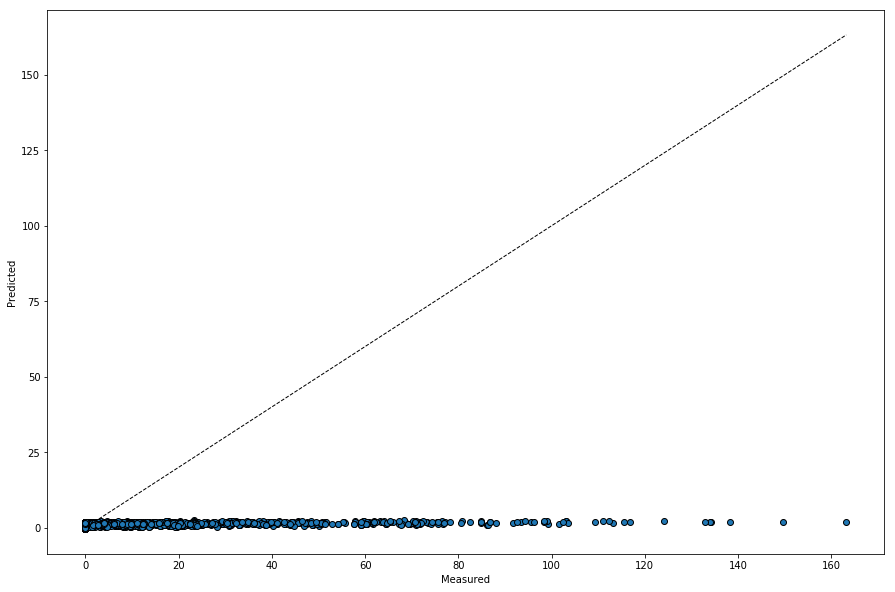

In [36]:
fig, ax = plt.subplots()
ax.scatter(y_test, predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()